# Tutorial 1: Ship Data Analysis

This tutorial covers: 
1. Loading movement data from common geospatial file formats (that are supported by GeoPandas)
1. Converting GeoDataFrames into Trajectories describing continuous tracks of moving objects
1. Filtering trajectories by area of interest
1. Splitting continuous tracks into individual trips
1. Exploring trip properties including: origins, destinations, and attributes 

This tutorial AIS uses data published by the Danish Maritime Authority. The AIS record sample extracted for this tutorial is located near Gothenburg and covers the 5th July 2017.

In [1]:
%matplotlib inline

In [2]:
import urllib
import os
import pandas as pd
import movingpandas as mp
import contextily as ctx
from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

## Area of interest: Gothenburg

Using zoom level 12, this will download 16 tiles
Wall time: 947 ms


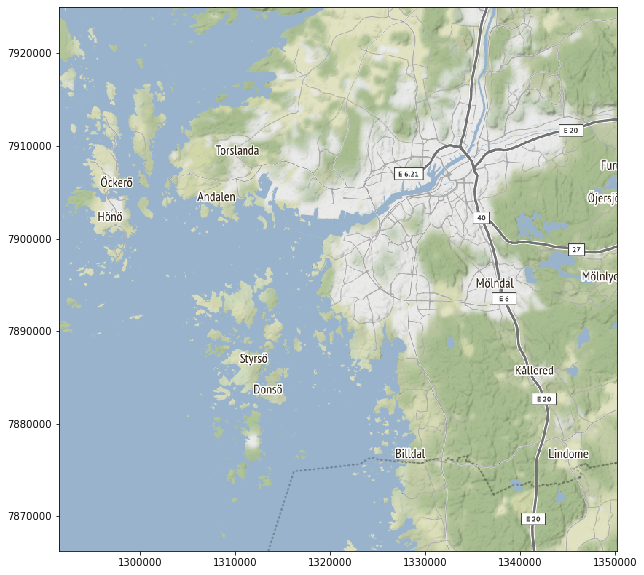

In [46]:
ZOOM_LEVEL = 12
w, s, e, n = 11.76, 57.61, 12, 57.73

# check number of tiles that will be downloaded
ctx.howmany(w, s, e, n, ZOOM_LEVEL, ll=True)

# download tiles
%time img, ext = ctx.bounds2img(w, s, e, n, ZOOM_LEVEL-1, ll=True)

# plot map 
plt.rcParams['figure.figsize'] = (10,10)
plt.imshow(img, extent=ext, aspect='auto')

## Loading Sample AIS data 


In [30]:
# Loading geodata ...
t_start = datetime.now()
df = read_file('demo/demo_ais.gpkg')
wgs84 = df.crs
df['t'] = pd.to_datetime(df['Timestamp'], format='%d/%m/%Y %H:%M:%S')
df = df.set_index('t')
print("Finished reading {} rows in {}".format(len(df),datetime.now() - t_start))

Finished reading 84702 rows in 0:00:05.217638


There are a lot of records with speed over ground (SOG) values of zero in this dataframe:

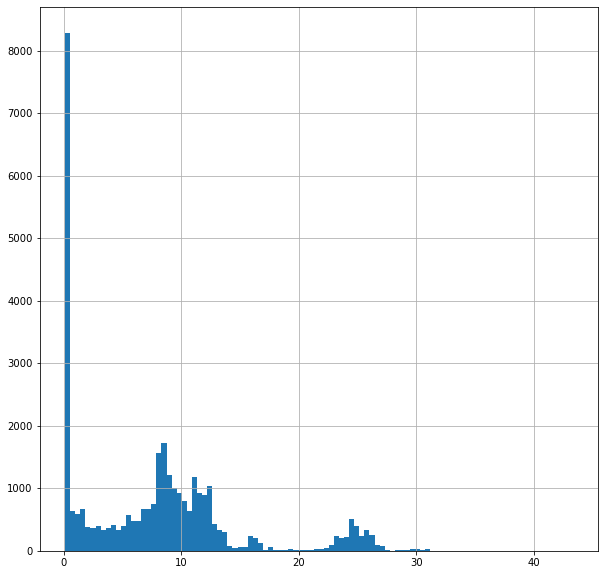

In [44]:
df['SOG'].hist(bins=100)

Let's get rid of these rows with zero SOG:

In [31]:
df = df[df.SOG>0]
print("Reduced to {} rows after removing 0 speed records".format(len(df)))

Reduced to 33593 rows after removing 0 speed records


Now, let's create trajectories:

In [45]:
MIN_LENGTH = 100 # meters

t_start = datetime.now()

trajectories = []
for key, values in df.groupby(['MMSI']):
    if len(values) < 2:
        continue
    trajectory = mp.Trajectory(key, values)
    if trajectory.get_length() < MIN_LENGTH:
        continue
    #print(trajectory)
    trajectories.append(trajectory)

print("Finished creating {} trajectories in {}".format(len(trajectories),datetime.now() - t_start))

Finished creating 77 trajectories in 0:00:06.425210


In [33]:
my_traj = trajectories[0]
my_traj.df

,Timestamp,MMSI,NavStatus,SOG,COG,Name,ShipType,geometry,prev_pt,dist_to_prev
t,,,,,,,,,,
2017-07-05 17:32:18,05/07/2017 17:32:18,210035000,Under way using engine,9.8,52.8,NORDIC HAMBURG,Cargo,POINT (11.80462 57.676125),NaN,0.000000
2017-07-05 17:32:28,05/07/2017 17:32:28,210035000,Under way using engine,9.8,51.0,NORDIC HAMBURG,Cargo,POINT (11.805283 57.676405),POINT (11.80462 57.676125),50.232021
2017-07-05 17:32:36,05/07/2017 17:32:36,210035000,Under way using engine,9.8,51.0,NORDIC HAMBURG,Cargo,POINT (11.805283 57.676405),POINT (11.805283 57.676405),0.000000
2017-07-05 17:32:38,05/07/2017 17:32:38,210035000,Under way using engine,9.8,51.0,NORDIC HAMBURG,Cargo,POINT (11.805283 57.676405),POINT (11.805283 57.676405),0.000000
2017-07-05 17:32:48,05/07/2017 17:32:48,210035000,Under way using engine,9.7,52.0,NORDIC HAMBURG,Cargo,POINT (11.806675 57.676992),POINT (11.805283 57.676405),105.403577
2017-07-05 17:32:59,05/07/2017 17:32:59,210035000,Under way using engine,9.6,55.6,NORDIC HAMBURG,Cargo,POINT (11.807418 57.677278),POINT (11.806675 57.676992),54.431358
2017-07-05 17:33:08,05/07/2017 17:33:08,210035000,Under way using engine,9.5,57.5,NORDIC HAMBURG,Cargo,POINT (11.808043 57.6775),POINT (11.807418 57.677278),44.611120
2017-07-05 17:33:18,05/07/2017 17:33:18,210035000,Under way using engine,9.5,58.9,NORDIC HAMBURG,Cargo,POINT (11.808747 57.677728),POINT (11.808043 57.6775),48.935041
2017-07-05 17:33:28,05/07/2017 17:33:28,210035000,Under way using engine,9.4,61.7,NORDIC HAMBURG,Cargo,POINT (11.809397 57.677917),POINT (11.808747 57.677728),43.989676


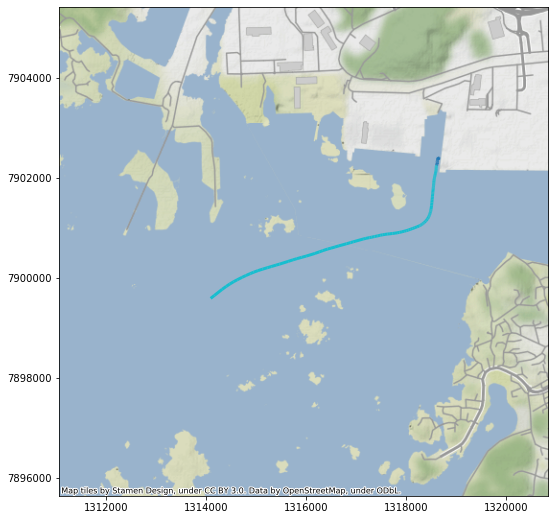

In [34]:
ZOOM_LEVEL = 13
my_traj.plot(with_basemap=True, linewidth=3.0, column='NavStatus', 
                          figsize=(9,9), url=ctx.sources.ST_TERRAIN, zoom=ZOOM_LEVEL) 

Note: When plotting with basemap, you may run into missing map tiles. For Stamen, you can check map tile availability for a region and zoom level at http://maps.stamen.com/#terrain/15/57.6714/11.8120

Available tile sources are listed in https://github.com/darribas/contextily/blob/master/contextily/tile_providers.py, e.g.

```
ST_TONER = 'http://tile.stamen.com/toner/{z}/{x}/{y}.png'
ST_TONER_HYBRID = 'http://tile.stamen.com/toner-hybrid/{z}/{x}/{y}.png'
ST_TONER_LABELS = 'http://tile.stamen.com/toner-labels/{z}/{x}/{y}.png'
ST_TONER_LINES = 'http://tile.stamen.com/toner-lines/{z}/{x}/{y}.png'
ST_TONER_BACKGROUND = 'http://tile.stamen.com/toner-background/{z}/{x}/{y}.png'
ST_TONER_LITE = 'http://tile.stamen.com/toner-lite/{z}/{x}/{y}.png'

ST_TERRAIN = 'http://tile.stamen.com/terrain/{z}/{x}/{y}.png'
ST_TERRAIN_LABELS = 'http://tile.stamen.com/terrain-labels/{z}/{x}/{y}.png'
ST_TERRAIN_LINES = 'http://tile.stamen.com/terrain-lines/{z}/{x}/{y}.png'
ST_TERRAIN_BACKGROUND = 'http://tile.stamen.com/terrain-background/{z}/{x}/{y}.png'

ST_WATERCOLOR = 'http://tile.stamen.com/watercolor/{z}/{x}/{y}.png'
```

More on plotting GeoPandas GeoDataframes: http://geopandas.org/gallery/plotting_basemap_background.html

## Finding ships passing under Älvsborgsbron bridge
We can find ships passing under the bridge based on trajectory intersections with the bridge area.

In [9]:
area_of_interest = Polygon([(11.89935, 57.69270), (11.90161, 57.68902), (11.90334, 57.68967), (11.90104, 57.69354), (11.89935, 57.69270)])

In [10]:
intersections = []
for traj in trajectories:
    if traj.to_linestring().intersects(area_of_interest):
        intersections.append(traj)
print("Found {} intersections".format(len(intersections)))

Found 20 intersections


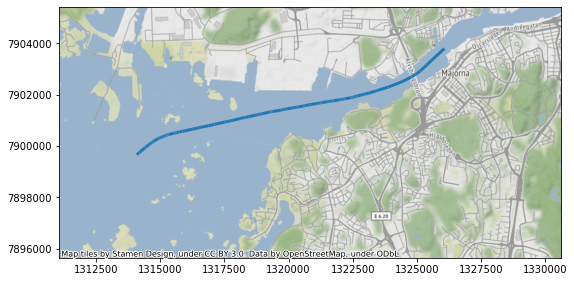

In [35]:
bridge_traj = intersections[0]
bridge_traj.plot(with_basemap=True, linewidth=3.0, column='NavStatus', 
                          figsize=(9,9), url=ctx.sources.ST_TERRAIN, zoom=ZOOM_LEVEL) 

In [36]:
bridge_traj.df

,Timestamp,MMSI,NavStatus,SOG,COG,Name,ShipType,geometry,prev_pt,dist_to_prev,line,t,gap
t,,,,,,,,,,,,,
2017-07-05 01:21:57,05/07/2017 01:21:57,219011922,Under way using engine,8.8,227.7,SCANDINAVIA,Tanker,POINT (11.9123 57.696335),NaN,0.000000,None,2017-07-05 01:21:57,0
2017-07-05 01:22:47,05/07/2017 01:22:47,219011922,Under way using engine,8.7,227.1,SCANDINAVIA,Tanker,POINT (11.909473 57.694925),POINT (11.9123 57.696335),229.789248,"LINESTRING (11.9123 57.696335, 11.909473 57.69...",2017-07-05 01:22:47,0
2017-07-05 01:23:06,05/07/2017 01:23:06,219011922,Under way using engine,8.7,227.5,SCANDINAVIA,Tanker,POINT (11.908422 57.694403),POINT (11.909473 57.694925),85.263842,"LINESTRING (11.909473 57.694925, 11.908422 57....",2017-07-05 01:23:06,0
2017-07-05 01:23:18,05/07/2017 01:23:18,219011922,Under way using engine,8.7,227.4,SCANDINAVIA,Tanker,POINT (11.907755 57.694078),POINT (11.908422 57.694403),53.638805,"LINESTRING (11.908422 57.694403, 11.907755 57....",2017-07-05 01:23:18,0
2017-07-05 01:23:47,05/07/2017 01:23:47,219011922,Under way using engine,8.7,226.8,SCANDINAVIA,Tanker,POINT (11.906183 57.693272),POINT (11.907755 57.694078),129.459054,"LINESTRING (11.907755 57.694078, 11.906183 57....",2017-07-05 01:23:47,0
2017-07-05 01:23:49,05/07/2017 01:23:49,219011922,Under way using engine,8.6,226.5,SCANDINAVIA,Tanker,POINT (11.906073 57.693217),POINT (11.906183 57.693272),8.951869,"LINESTRING (11.906183 57.693272, 11.906073 57....",2017-07-05 01:23:49,0
2017-07-05 01:24:06,05/07/2017 01:24:06,219011922,Under way using engine,8.7,227.0,SCANDINAVIA,Tanker,POINT (11.905147 57.692748),POINT (11.906073 57.693217),75.816113,"LINESTRING (11.906073 57.693217, 11.905147 57....",2017-07-05 01:24:06,0
2017-07-05 01:24:21,05/07/2017 01:24:21,219011922,Under way using engine,8.6,228.3,SCANDINAVIA,Tanker,POINT (11.90437 57.692372),POINT (11.905147 57.692748),62.292092,"LINESTRING (11.905147 57.692748, 11.90437 57.6...",2017-07-05 01:24:21,0
2017-07-05 01:24:26,05/07/2017 01:24:26,219011922,Under way using engine,8.7,229.9,SCANDINAVIA,Tanker,POINT (11.904032 57.692213),POINT (11.90437 57.692372),26.759713,"LINESTRING (11.90437 57.692372, 11.904032 57.6...",2017-07-05 01:24:26,0


## Identifying trip origins and destinations

Since AIS records with a speed over ground (SOG) value of zero have been removed from the dataset, we can use the `split_by_observation_gap()` function to split the continuous observations into individual trips:

In [13]:
trips = []
for traj in trajectories:
    for x in traj.split_by_observation_gap(timedelta(minutes=5)):
        if x.get_length() > MIN_LENGTH:
            trips.append(x)
print("Extracted {} individual trips from {} continuous vessel tracks".format(len(trips), len(trajectories)))

Extracted 302 individual trips from 77 continuous vessel tracks


In [27]:
origins = []
for trip in trips:
    origins.append({'geometry': trip.get_start_location(), 'id': trip.id, 
                    'SOG': trip.df.head(1)['SOG'][0], 'ShipType': trip.df.head(1)['ShipType'][0]})
origins = GeoDataFrame(pd.DataFrame(origins), crs=wgs84)

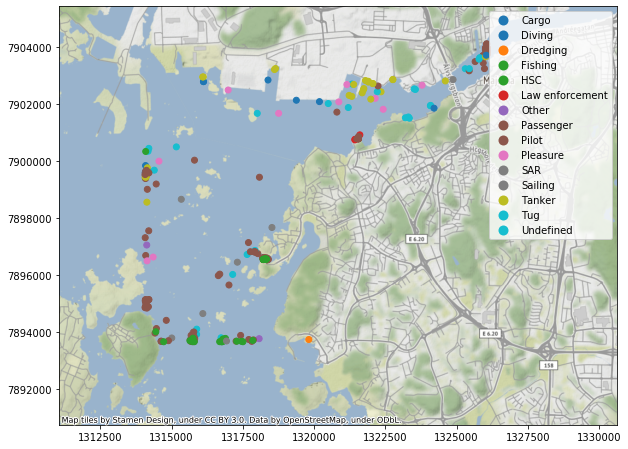

In [41]:
ax = origins.set_geometry('geometry')[1:].to_crs(epsg=3857).plot(column='ShipType', legend=True)
ctx.add_basemap(ax, url=ctx.sources.ST_TERRAIN, zoom=ZOOM_LEVEL)

In our data sample, trip origins can can be:
- When a ship departs it's anchoring location and the speed changes from 0 to >0
- When a ship trajectory first enters the observation area

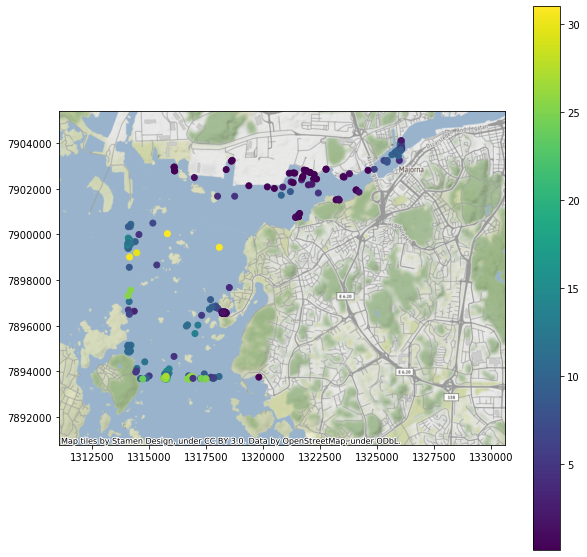

In [42]:
ax = origins.set_geometry('geometry')[1:].to_crs(epsg=3857).plot(column='SOG', legend=True)
ctx.add_basemap(ax, url=ctx.sources.ST_TERRAIN, zoom=ZOOM_LEVEL)

## Finding ships that depart from Sjöfartsverket (Maritime Administration)

In [15]:
area_of_interest = Polygon([(11.86815, 57.68273), (11.86992, 57.68047), (11.87419, 57.68140), (11.87288, 57.68348), (11.86815, 57.68273)])

We can identify vessels that start their trip within a given area of interst by intersecting trip starting locations with our area of interest:

In [16]:
departures = []
for traj in trips:
    if traj.get_start_location().intersects(area_of_interest):
        departures.append(traj)
print("Found {} departures".format(len(departures)))

Found 12 departures


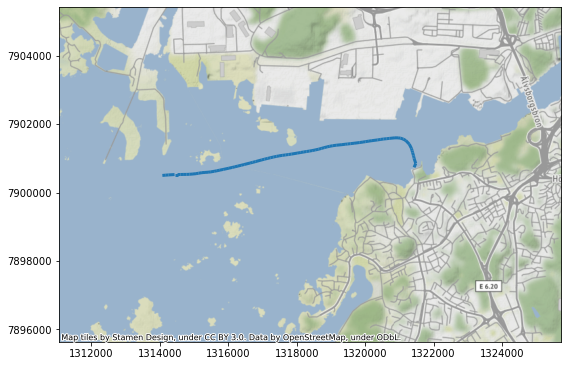

In [17]:
departures[1].plot(with_basemap=True, linewidth=3.0, column='NavStatus', 
                          figsize=(9,9), url=ctx.sources.ST_TERRAIN, zoom=ZOOM_LEVEL) 

Let's see what kind of ships depart from here:

In [18]:
for traj in departures:
    print("{} vessel '{}' departed at {}".format(traj.df['ShipType'].iloc[0], traj.df['Name'].iloc[0], traj.get_start_time()))

Law enforcement vessel 'KBV 010' departed at 2017-07-05 10:36:03
Law enforcement vessel 'KBV 010' departed at 2017-07-05 14:33:02
Law enforcement vessel 'KBV 048' departed at 2017-07-05 10:20:44
Pilot vessel 'PILOT 794 SE' departed at 2017-07-05 01:21:07
Pilot vessel 'PILOT 794 SE' departed at 2017-07-05 04:15:04
Pilot vessel 'PILOT 794 SE' departed at 2017-07-05 06:58:56
Pilot vessel 'PILOT 794 SE' departed at 2017-07-05 08:45:08
Pilot vessel 'PILOT 794 SE' departed at 2017-07-05 12:02:18
Pilot vessel 'PILOT 794 SE' departed at 2017-07-05 13:34:42
Pilot vessel 'PILOT 794 SE' departed at 2017-07-05 22:32:47
Pilot vessel 'PILOT 218 SE' departed at 2017-07-05 09:27:24
Pilot vessel 'PILOT 218 SE' departed at 2017-07-05 16:10:29


Of course, the same works for arrivals:

In [19]:
arrivals = []
for traj in trips:
    if traj.get_end_location().intersects(area_of_interest):
        arrivals.append(traj)
print("Found {} arrivals".format(len(arrivals)))

for traj in arrivals:
    print("{} vessel '{}' arrived at {}".format(traj.df['ShipType'].iloc[0], traj.df['Name'].iloc[0], traj.get_end_time()))

Found 12 arrivals
Law enforcement vessel 'KBV 010' arrived at 2017-07-05 10:51:03
Law enforcement vessel 'KBV 048' arrived at 2017-07-05 10:26:44
Pilot vessel 'PILOT 794 SE' arrived at 2017-07-05 01:37:37
Pilot vessel 'PILOT 794 SE' arrived at 2017-07-05 04:51:27
Pilot vessel 'PILOT 794 SE' arrived at 2017-07-05 08:16:46
Pilot vessel 'PILOT 794 SE' arrived at 2017-07-05 08:55:18
Pilot vessel 'PILOT 794 SE' arrived at 2017-07-05 13:06:55
Pilot vessel 'PILOT 794 SE' arrived at 2017-07-05 16:44:06
Pilot vessel 'PILOT 794 SE' arrived at 2017-07-05 23:58:49
Pilot vessel 'PILOT 218 SE' arrived at 2017-07-05 10:08:03
Pilot vessel 'PILOT 218 SE' arrived at 2017-07-05 17:46:12
Tanker vessel 'DANA' arrived at 2017-07-05 08:35:48
